In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
def main_func(x, y):
  return (x - y) * np.sin(x + y)

class FirstModel(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.relu = nn.ReLU()
    self.layer_2 = nn.Linear(in_features=10, out_features=1)


  def forward(self, x):
    return self.layer_2(self.relu(self.layer_1(main_func(x[0], x[1]))))

model_0 = FirstModel()
model_0

FirstModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
def main_func(x, y):
  return (x - y) * np.sin(x + y)

x = np.linspace(-8, 8, 160)
y = np.linspace(-4, 4, 160)
z = main_func(x, y)

# Reshape and split
x_y_data = np.column_stack((x.ravel(), y.ravel()))
z_data = z.ravel()

# Train-test split
x_y_train, x_y_test, z_train, z_test = train_test_split(x_y_data, z_data, test_size=0.4, random_state=42)

# Normalize inputs
scaler = StandardScaler()
x_y_train = scaler.fit_transform(x_y_train)
x_y_test = scaler.transform(x_y_test)

# Convert to tensors
X_Y_train = torch.FloatTensor(x_y_train)
X_Y_test = torch.FloatTensor(x_y_test)
Z_train = torch.FloatTensor(z_train) # Unsqueeze for compatibility
Z_test = torch.FloatTensor(z_test)

X_Y_train.shape, X_Y_test.shape, Z_train.shape, Z_test.shape

(torch.Size([96, 2]), torch.Size([64, 2]), torch.Size([96]), torch.Size([64]))

In [ ]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, input_size, hidden_layers):
    super(FeedForwardNetwork, self).__init__()
    layers = []
    prev_size = input_size

    for hidden_size in hidden_layers:
      layers.append(nn.Linear(prev_size, hidden_size))

      layers.append(nn.ReLU())
      prev_size = hidden_size

    layers.append(nn.Linear(prev_size, 1))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [ ]:
class CascadeNetwork(nn.Module):
  def __init__(self, input_size, hidden_layers):
    super(CascadeNetwork, self).__init__()
    self.hidden_layers = nn.ModuleList()
    self.input_size = input_size
    prev_size = input_size

    for hidden_size in hidden_layers:
      self.hidden_layers.append(nn.Linear(prev_size + input_size, hidden_size))
      prev_size = hidden_size

    self.output = nn.Linear(prev_size + input_size, 1)

  def forward(self, x):
    out = x
    for layer in self.hidden_layers:
      out = torch.cat([x, out], dim=1)
      out = torch.relu(layer(out))
    out = torch.cat([x, out], dim=1)
    return self.output(out)

In [ ]:
class ElmanNetwork(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size=1):
    super(ElmanNetwork, self).__init__()
    self.hidden_sizes = hidden_sizes
    self.input_to_hidden = nn.ModuleList(
    [nn.Linear(input_size + hidden_size, hidden_size) for hidden_size in hidden_sizes]
    )
    self.hidden_to_output = nn.Linear(hidden_sizes[-1], output_size)
    self.tanh = nn.Tanh()

  def forward(self, x, hidden):
    combined = torch.cat((x, hidden[0]), 1)
    hidden_next = []

    for i, input_to_hidden_layer in enumerate(self.input_to_hidden):
      hidden_i = self.tanh(input_to_hidden_layer(combined))
      combined = torch.cat((x, hidden_i), 1)
      hidden_next.append(hidden_i)

    output = self.hidden_to_output(hidden_next[-1])
    return output, hidden_next

  def init_hidden(self, batch_size):
    return [torch.zeros(batch_size, hidden_size) for hidden_size in self.hidden_sizes]

In [ ]:
def train_model(model, epochs=500, learning_rate=0.01):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  loss_curve = []

  def initialize_weights(m):
    if isinstance(m, nn.Linear):
      nn.init.xavier_uniform_(m.weight)

  model.apply(initialize_weights)

  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    if isinstance(model, ElmanNetwork):
      hidden_state = model.init_hidden(X_Y_train.size(0))
      output, hidden_state = model(X_Y_train, hidden_state)
    else:
      output = model(X_Y_train)

    loss = criterion(output, Z_train.unsqueeze(1))
    loss.backward()
    optimizer.step()
    loss_curve.append(loss.item())

  model.eval()
  with torch.no_grad():
    if isinstance(model, ElmanNetwork):
      hidden_state = model.init_hidden(X_Y_test.size(0))
      predictions, hidden_state = model(X_Y_test, hidden_state)
      # full_mse = mean_squared_error(z_data, predictions.detach().numpy().squeeze())
      full_mse = mean_squared_error(Z_test.detach().numpy().squeeze(), predictions.detach().numpy().squeeze())
    else:
      predictions = model(X_Y_test)
      if not isinstance(model, ElmanNetwork):
        full_predictions = model(torch.FloatTensor(x_y_data))
      else :
        full_predictions = model(torch.FloatTensor(x_y_data), model.init_hidden(x_y_data.shape[0]))[0]
      full_mse = mean_squared_error(z_data, full_predictions.detach().numpy().squeeze())

  return predictions, full_mse, loss_curve


MSE: 16.3096


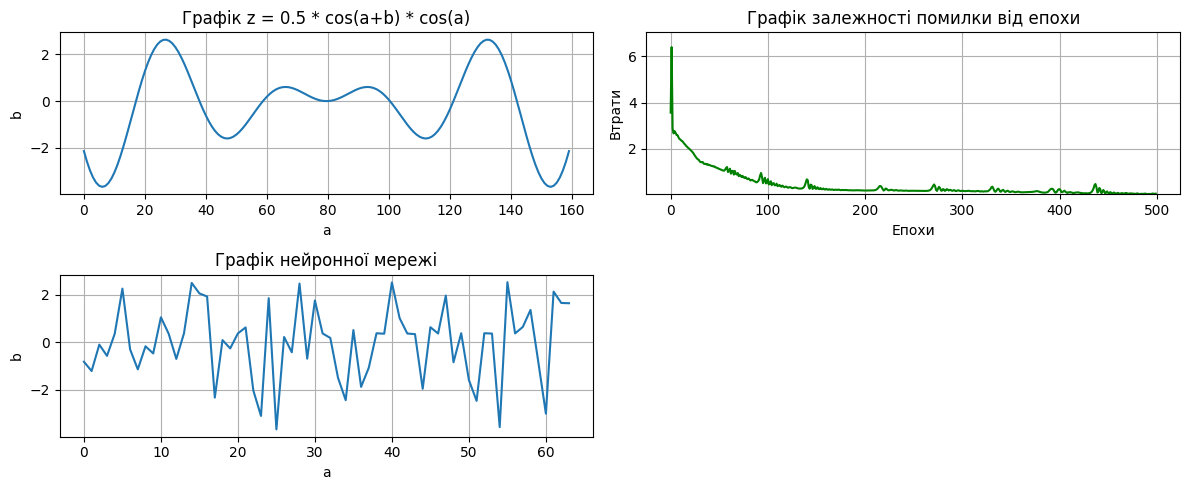

In [ ]:
while True:
  user_choice = input("Input: ")
  if user_choice == '1':
    model = FeedForwardNetwork(input_size=2, hidden_layers=[50, 50])
  elif user_choice == '2':
    model = FeedForwardNetwork(input_size=2, hidden_layers=[20])
  elif user_choice == '3':
    model = CascadeNetwork(input_size=2, hidden_layers=[20])
  elif user_choice == '4':
    model = CascadeNetwork(input_size=2, hidden_layers=[10, 10])
  elif user_choice == '5':
    model = ElmanNetwork(input_size=2, hidden_sizes=[15])
  elif user_choice == '6':
    model = ElmanNetwork(input_size=2, hidden_sizes=[5, 5, 5])
  elif user_choice == '7':
    break
  else:
    continue

  predictions, mse, loss_curve = train_model(model, epochs=500, learning_rate=0.05)
  print(f"\nMSE: {mse:.4f}")

  plt.figure(figsize=(12, 5))
  plt.subplot(2, 2, 1)
  plt.plot(z_data)
  plt.title('Графік z = 0.5 * cos(a+b) * cos(a)')
  plt.xlabel('a')
  plt.ylabel('b')
  plt.grid()

  plt.subplot(2, 2, 3)
  plt.plot(predictions)
  plt.title('Графік нейронної мережі')
  plt.xlabel('a')
  plt.ylabel('b')
  plt.grid()

  plt.subplot(2, 2, 2)
  plt.plot(loss_curve, color='green')
  plt.xlabel('Епохи')
  plt.ylabel('Втрати')
  plt.title('Графік залежності помилки від епохи')
  plt.ylim(min(loss_curve) * 0.9, max(loss_curve) * 1.1)
  plt.grid()
  plt.tight_layout()
  plt.show()